# TITLE: Using GPUs in PyTorch


## Imports

In [ ]:
import torch
import time
import matplotlib.pyplot as plt

## GPU Availability and Device Setting


In [ ]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("GPU is not available. Using CPU.")

GPU is available. Using GPU: Tesla T4


## Moving Tensors Between Devices


In [ ]:
# Create a tensor (it will be on CPU by default)
tensor_cpu = torch.tensor([1, 2, 3])
print(f"Tensor created on: {tensor_cpu.device}")

# Move the tensor to the selected device (GPU if available, otherwise CPU)
tensor_on_device = tensor_cpu.to(device)
print(f"Tensor moved to: {tensor_on_device.device}")

# If the tensor is on GPU, we can move it back to CPU
if tensor_on_device.device.type == 'cuda':
    tensor_back_to_cpu = tensor_on_device.to('cpu')
    print(f"Tensor moved back to: {tensor_back_to_cpu.device}")

Tensor created on: cpu
Tensor moved to: cuda:0
Tensor moved back to: cpu


## Device Consistency for Operations


In [ ]:
tensor_a_cpu = torch.tensor([1.0, 2.0, 3.0], device='cpu')
# tensor_b_device will be created on the 'device' determined earlier (CPU or GPU)
tensor_b_device = torch.tensor([4.0, 5.0, 6.0]).to(device)

print(f"tensor_a_cpu is on: {tensor_a_cpu.device}")
print(f"tensor_b_device is on: {tensor_b_device.device}")

try:
    # This will cause an error if tensor_a_cpu and tensor_b_device are on different devices
    # (i.e., if 'device' is 'cuda')
    result_mixed = tensor_a_cpu + tensor_b_device
    print(f"\nSum of tensors (mixed devices attempt succeeded): {result_mixed}")
    if tensor_a_cpu.device == tensor_b_device.device:
        print("This succeeded because both tensors were already on the same device (CPU).")
except RuntimeError as e:
    print(f"\nError during mixed device operation: {e}")
    print("This error occurred because the tensors are on different devices (CPU and GPU).")

# To fix this, ensure both tensors are on the same device before the operation:
print("\nFixing the device mismatch (if any) by ensuring tensor_a is on the target device:")
tensor_a_on_target_device = tensor_a_cpu.to(device) # Move tensor_a_cpu to the same device as tensor_b_device
print(f"tensor_a_cpu (now tensor_a_on_target_device) is on: {tensor_a_on_target_device.device}")

# Now the operation will succeed
result_same_device = tensor_a_on_target_device + tensor_b_device
print(f"Sum of tensors (both on device '{device}'): {result_same_device}")
print(f"Result tensor is on: {result_same_device.device}")

tensor_a_cpu is on: cpu
tensor_b_device is on: cuda:0

Error during mixed device operation: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!
This error occurred because the tensors are on different devices (CPU and GPU).

Fixing the device mismatch (if any) by ensuring tensor_a is on the target device:
tensor_a_cpu (now tensor_a_on_target_device) is on: cuda:0
Sum of tensors (both on device 'cuda'): tensor([5., 7., 9.], device='cuda:0')
Result tensor is on: cuda:0


## CPU vs GPU Matrix Multiplication Benchmark


In [ ]:
size = 2000  # Size of the square matrices (e.g., 2000x2000)

# Create two large matrices for CPU computation
matrix1_cpu = torch.randn(size, size, device='cpu')
matrix2_cpu = torch.randn(size, size, device='cpu')

# CPU benchmark
print(f"\nStarting CPU benchmark for {size}x{size} matrix multiplication...")
start_time_cpu = time.time()
result_cpu = torch.matmul(matrix1_cpu, matrix2_cpu)
end_time_cpu = time.time()
cpu_time = end_time_cpu - start_time_cpu
print(f"CPU time: {cpu_time:.4f} seconds")

# GPU benchmark (only if GPU is available)
gpu_time = float('inf')  # Initialize with a high value

if device.type == 'cuda':
    print(f"\nStarting GPU benchmark for {size}x{size} matrix multiplication on {torch.cuda.get_device_name(0)}...")
    # Create matrices directly on the GPU for a fair comparison of compute time
    # (Alternatively, one could move existing CPU matrices, which would include transfer time)
    matrix1_gpu = torch.randn(size, size, device=device)
    matrix2_gpu = torch.randn(size, size, device=device)

    # Warm-up GPU (optional, but can give more stable timings for the first timed operation)
    # _ = torch.matmul(matrix1_gpu, matrix2_gpu)
    # torch.cuda.synchronize()

    # Ensure all previous CUDA operations are done before starting the timer
    torch.cuda.synchronize()
    start_time_gpu = time.time()
    result_gpu = torch.matmul(matrix1_gpu, matrix2_gpu)
    # Wait for the GPU operation to complete before stopping the timer
    torch.cuda.synchronize()
    end_time_gpu = time.time()
    gpu_time = end_time_gpu - start_time_gpu
    print(f"GPU time: {gpu_time:.4f} seconds")

    # Optional: Verify results are close (they might not be exactly identical due to floating point arithmetic differences)
    # print(f"Are CPU and GPU results close? {torch.allclose(result_cpu.to(device), result_gpu, atol=1e-5)}")
else:
    print("\nGPU benchmark skipped as GPU is not available.")


Starting CPU benchmark for 2000x2000 matrix multiplication...
CPU time: 0.5448 seconds

Starting GPU benchmark for 2000x2000 matrix multiplication on Tesla T4...
GPU time: 0.3148 seconds


## Visualizing Benchmark Results



Speedup with GPU: 1.73x


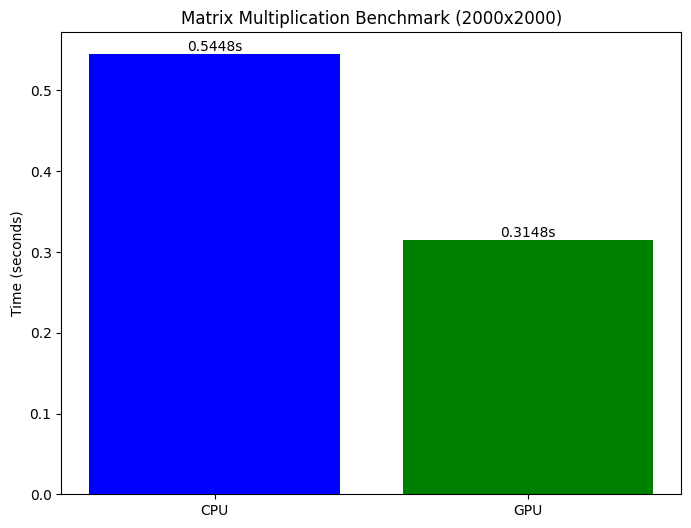

In [ ]:
labels = ['CPU']
times = [cpu_time]
colors = ['blue']

if device.type == 'cuda' and gpu_time != float('inf') and gpu_time > 0: # Check gpu_time > 0 to avoid division by zero
    labels.append('GPU')
    times.append(gpu_time)
    colors.append('green') # Assign a specific color for GPU
    print(f"\nSpeedup with GPU: {cpu_time / gpu_time:.2f}x")
elif device.type == 'cuda' and (gpu_time == float('inf') or gpu_time <= 0) :
    print("\nGPU benchmark ran, but a valid positive time was not recorded. Cannot calculate speedup.")
else: # GPU not available or benchmark not run
    print("\nGPU not used for benchmark, so no speedup comparison.")


plt.figure(figsize=(8, 6))
bars = plt.bar(labels, times, color=colors) # Use the defined colors list
plt.ylabel('Time (seconds)')
plt.title(f'Matrix Multiplication Benchmark ({size}x{size})')

# Add text labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}s', va='bottom', ha='center')

plt.show()